# CML wet/dry detection on 1 CML using CNN architecture of Polz J. [2]

__CML data:__  
Imported from pycomlink (Chwala C:): https://github.com/pycomlink/pycomlink

__Sources: All code from [2]__  
github: https://github.com/jpolz/cml_wd_pytorch/tree/main  
thesis: https://doi.org/10.5194/amt-13-3835-2020

In [1]:
import cnn
import xarray as xr               # work with arrays, also possible with pandas
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
# import einops
import matplotlib.pyplot as plt
import sklearn.metrics as skl

In [2]:
from sklearn.utils import shuffle
from tqdm import tqdm
from IPython.display import clear_output


#### Load CML data
Import data of 500 CML links from pycomlink with 1min timestep

In [3]:
# 500 CMLs with 1 min time step
cml_set = xr.open_dataset('example_data/example_cml_data.nc', engine='netcdf4') # https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html

# Temporarily remove GPS coordinates - might add later with additional cml info for better CNN learning
# https://stackoverflow.com/questions/61003361/drop-coordinate-from-an-xarray-dataarray
cml_set = cml_set.reset_coords(['site_a_latitude','site_b_latitude','site_a_longitude','site_b_longitude'], drop=True)

#### Load Reference data
Reference rain rate data from RADOLAN. With 5 min step

In [4]:
# reference RADOLAN data from pycomlink with 5 min time step
# Path averaged reference RADOLAN data aligned with all 500 CML IDs
ref_set = xr.open_dataset('example_data/example_path_averaged_reference_data.nc', engine='netcdf4')

## CML data preprocessing
1. choosing cml for training  
2. replacing fault values
3. cnalculating TRSL
4. resampling data  
5. creating dataset of training and reference data + data visualisation
6. Standardising

All from pycomlink https://github.com/pycomlink/pycomlink/blob/master/notebooks/Basic%20CML%20processing%20workflow.ipynb

#### Choose one CML, repair fault data and calculate TRSL

In [5]:
# Choose one cml
k = 14; # index of chosen cml 0-499
my_cml = cml_set.isel(cml_id = k) # https://docs.xarray.dev/en/latest/generated/xarray.Dataset.assign.html
my_ref = ref_set.isel(cml_id = k)

# Check for fault data in TSL, RSL and replace it with NaN https://github.com/jpolz/cml_wd_pytorch/tree/main
my_cml['tsl'] = my_cml.tsl.where(my_cml.tsl != 255.0)
my_cml['rsl'] = my_cml.rsl.where(my_cml.rsl != -99.9)
# Calculate TRSL
my_cml['trsl'] = my_cml.tsl - my_cml.rsl

# show CML dataset
my_cml

<xarray.Dataset> Size: 887kB
Dimensions:       (time: 15840, channel_id: 2)
Coordinates:
  * time          (time) datetime64[ns] 127kB 2018-05-10 ... 2018-05-20T23:59:00
    cml_id        <U3 12B '14'
    length        float64 8B ...
  * channel_id    (channel_id) <U9 72B 'channel_1' 'channel_2'
    frequency     (channel_id) float64 16B ...
    polarization  (channel_id) <U1 8B ...
Data variables:
    rsl           (channel_id, time) float64 253kB -41.6 -42.0 ... -44.5 -44.5
    tsl           (channel_id, time) float64 253kB 19.0 19.0 19.0 ... 19.0 19.0
    trsl          (channel_id, time) float64 253kB 60.6 61.0 61.0 ... 63.5 63.5

#### Interpolate misising values

In [6]:
# From pycomlink
my_cml['trsl'] = my_cml.trsl.interpolate_na(dim='time', method='linear', max_gap='5min')


#### Resample CML data to 5 min step 

In [7]:
# maybe try to calculate rate of resampling from cml and ref data
my_cml = my_cml.resample(time="5min").mean() # from Pycomlink
# len(my_cml.time)

#### Align to a dataset with Reference RADOLAN data and calculate boolean Wet/dry Reference flag

In [8]:
my_data_set = my_cml.assign(my_ref)
# From reference rain rate derivate boolean reference Wet/Dry signal
my_data_set['ref_wet_dry'] = my_ref.rainfall_amount.where(my_ref.rainfall_amount == 0, True) # ChatGPT
# convert float value to bool for plotting the shaded areas from Pycomlink
my_data_set['ref_wet_dry'] = my_data_set.fillna(0).ref_wet_dry.astype(bool)
# my_data_set

In [9]:
# For simplification drop RSL, TSL, rainfall amount
my_data_set = my_data_set.reset_coords(['rsl','tsl','rainfall_amount'], drop=True)

#### Plot dataset of the one chosen cml 

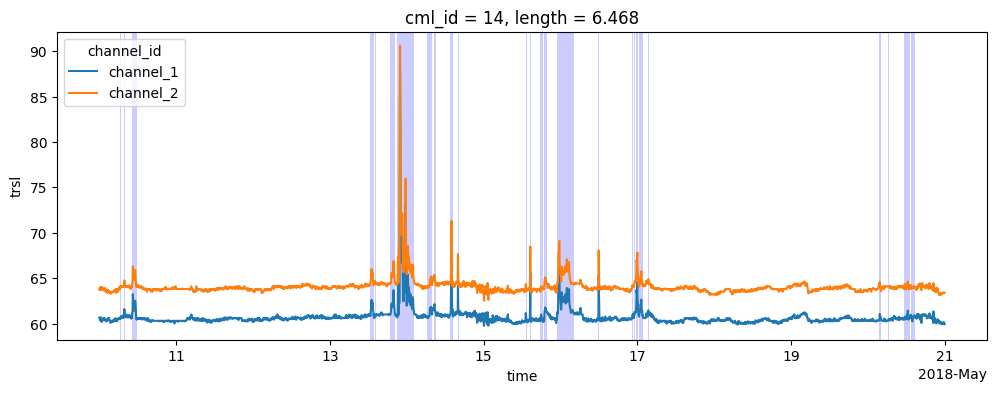

In [10]:
# shaded refernece wet periods from Pycomlink
# set first and last value with zero for correct plotting
my_data_set['ref_wet_dry'][0] = 0 
my_data_set['ref_wet_dry'][-1] = 0 

# seup figure
fig, ax = plt.subplots(figsize=(12,4), sharex=True)
my_data_set.trsl.plot.line(x='time', ax=ax, label = 'TL');

wet_start = np.roll(my_data_set.ref_wet_dry, -1) & ~my_data_set.ref_wet_dry
wet_end = np.roll(my_data_set.ref_wet_dry, 1) & ~my_data_set.ref_wet_dry
for wet_start_i, wet_end_i in zip(
    wet_start.values.nonzero()[0],
    wet_end.values.nonzero()[0],
):
    ax.axvspan(my_data_set.time.values[wet_start_i], my_data_set.time.values[wet_end_i], color='b', alpha=0.2, linewidth=0) # https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.axvspan.html

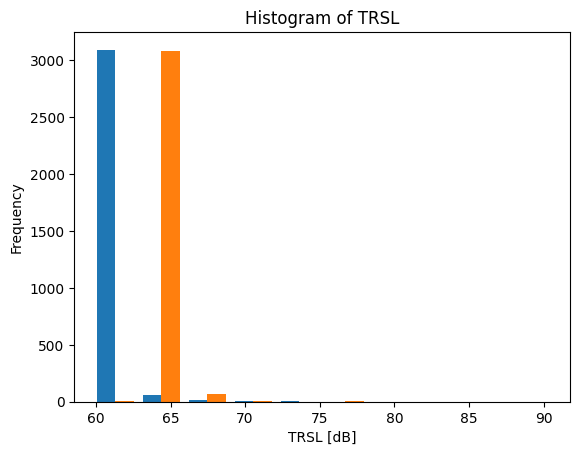

In [11]:
# histogram from: https://isibrno.cz/deep/
plt.figure()
plt.hist(my_data_set.trsl)
plt.title(f'Histogram of TRSL')
plt.xlabel('TRSL [dB]')
plt.ylabel('Frequency')
plt.show()

#### Agregate each 120 measurements into sample
To build samples for CNN and to make shuffle possible.  
120 times 5 min time step = 10 hour time window   
source: chatGPT

In [39]:
x = my_data_set.cml_id.values

In [12]:
# extract metadata:
# !!!!!!!!!!!!!!!!!!!!!!!!!! repair to make them strings
cml_id = my_data_set.cml_id.values
length = my_data_set.length.values
frequency = my_data_set.frequency.values
polarization = my_data_set.polarization.values

In [22]:
sample_size = 120 # 10 h
# get number of samples 
n_samples = len(my_data_set.time) // sample_size 
n_samples

26

In [25]:
# Reshape dataset to a new shape with the sample_id dimension
# last few points cant make a sample. Has to be cut off. 
trsl_reshaped = my_data_set['trsl'].values[0:(n_samples*sample_size)] 
# reshape
trsl_reshaped = trsl_reshaped.reshape(n_samples, 2, sample_size)   #2 stands for 2 channels
trsl_reshaped

array([[[60.64, 63.74, 60.6 , ..., 63.5 , 60.3 , 63.5 ],
        [60.54, 63.62, 60.6 , ..., 63.8 , 60.6 , 63.98]],

       [[60.68, 64.04, 60.54, ..., 63.68, 60.36, 63.5 ],
        [60.3 , 63.74, 60.6 , ..., 63.8 , 60.3 , 63.8 ]],

       [[60.18, 63.8 , 60.18, ..., 63.8 , 60.3 , 63.8 ],
        [60.3 , 63.8 , 60.3 , ..., 63.5 , 60.42, 63.5 ]],

       ...,

       [[60.3 , 64.1 , 60.42, ..., 63.8 , 60.42, 63.8 ],
        [60.3 , 63.8 , 60.3 , ..., 63.56, 60.3 , 63.62]],

       [[60.3 , 63.62, 60.36, ..., 63.86, 60.36, 63.8 ],
        [60.54, 63.8 , 60.42, ..., 64.1 , 60.48, 63.98]],

       [[60.48, 63.98, 60.54, ..., 64.04, 60.64, 63.8 ],
        [60.62, 63.86, 60.68, ..., 63.8 , 60.54, 63.92]]])

In [27]:
# last few points cant make a sample. Has to be cut off. 
ref_reshaped = my_data_set['ref_wet_dry'].values[0:(n_samples*sample_size)] 
# reshape
ref_reshaped = ref_reshaped.reshape(n_samples, sample_size)
ref_reshaped

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [43]:
# Create a new xarray Dataset with sample_num as a dimension
# replace time and date with timestamp in the time sample
ds = xr.Dataset({
    'trsl': (('sample_num', 'channel_id', 'timestamp'), trsl_reshaped),
    'ref_wet_dry': (('sample_num', 'timestamp'), ref_reshaped)
}, coords={'sample_num': np.arange(n_samples),
           'channel_id': np.arange(2),
           'timestamp': np.arange(sample_size),
           'cml_id': cml_id,
           'length': length,
           'frequency': (('channel_id'), frequency),
           'polarization': (('channel_id'), polarization)})
            # , 'frequency': frequency, 'polarization': polarization # TODO

# Print the reshaped dataset
ds

<xarray.Dataset> Size: 54kB
Dimensions:       (sample_num: 26, channel_id: 2, timestamp: 120)
Coordinates:
  * sample_num    (sample_num) int64 208B 0 1 2 3 4 5 6 ... 19 20 21 22 23 24 25
  * channel_id    (channel_id) int64 16B 0 1
  * timestamp     (timestamp) int64 960B 0 1 2 3 4 5 ... 114 115 116 117 118 119
    cml_id        <U3 12B '14'
    length        float64 8B 6.468
    frequency     (channel_id) float64 16B 2.592e+10 2.491e+10
    polarization  (channel_id) <U1 8B 'V' 'V'
Data variables:
    trsl          (sample_num, channel_id, timestamp) float64 50kB 60.64 ... ...
    ref_wet_dry   (sample_num, timestamp) bool 3kB False False ... False False

#### <span style="color:red">TODO: </span>Standardising
Subtracting the median of all available data from the preceding 72h from each time step [2] 


#### <span style="color:red">TODO: </span>We need to make Wet/Dry periods 50:50 for the training

In [ ]:
# ds = ds.isel(sample_number=np.arange(100))

#### Optional: save to CSV for data check

In [ ]:
if 0:
    df = my_data_set.to_dataframe()
    df.to_csv('df.csv')

## Train the CNN

In [ ]:
# extract metadata
metadata = xr.Coordinates(my_data_set.coords)

my_data_set = my_data_set.reset_coords(['length','cml_id','frequency','polarization'], drop=True)

In [ ]:
# transpose coordinates (time first, channel_id last)
# my_data_set['trsl'] = my_data_set.trsl.transpose('time','channel_id')

#### <span style="color:red">TODO: </span>Training/Testing/validation data splitting
https://github.com/jpolz/cml_wd_pytorch/blob/main/wd_pytorch/train_cnn.ipynb [2]

In [ ]:
batchsize = 180
k_train = 0.8     # fraction of training data

train_size = int(len(my_data_set.time)*k_train/batchsize)* batchsize
train_size

#### Convert to Tensor DataSets

Shuffling data, splitting and turning to arrays

In [ ]:
# shuffling disabled: because we dont work with samples of several timestamps, only vector of timestamps
# trsl, ref = shuffle(my_data_set.trsl.values, my_data_set.ref_wet_dry.values)
trsl = my_data_set.trsl.values
ref = my_data_set.ref_wet_dry.values

train_data = trsl[:train_size]
test_data = trsl[train_size:]
train_ref = ref[:train_size]
test_ref = ref[train_size:]
# to floor batch size use: data = data[:int(len(data/batch_size))*batch_size]

In [ ]:
train_data

In [ ]:
train_ref

Storing as tensors

In [ ]:
# Transposing 2 channels from columns ito rows, source: https://pytorch.org/docs/stable/generated/torch.transpose.html
train_data = torch.Tensor(train_data)#,0,1)#torch.transpose(
test_data = torch.Tensor(test_data)#,0,1)
# reference data is already orizontal vector
train_ref = torch.Tensor(train_ref)#.view(-1,1)
test_ref = torch.Tensor(test_ref)#.view(-1,1)

In [ ]:
train_ref

In [ ]:
len(train_ref)

In [ ]:
len(train_data)

Turning into dataset, shuffling

In [ ]:
dataset = torch.utils.data.TensorDataset(train_data, train_ref)
testset = torch.utils.data.TensorDataset(test_data, test_ref)

trainloader = torch.utils.data.DataLoader(dataset, batch_size = batchsize, shuffle = True)    # shuffle the training data
testloader = torch.utils.data.DataLoader(testset, batch_size = batchsize, shuffle = False)

In [ ]:
len(dataset)

In [ ]:
model = cnn.cnn_class()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)


In [ ]:
epochs = 10
resume = 0

In [ ]:
if resume == 0:
    loss_dict = {}
    loss_dict['train'] = {}
    loss_dict['test'] = {}
    for key in ['train','test']:
        loss_dict[key]['loss'] = []

In [ ]:
for epoch in range(resume, epochs):
    # training
    train_losses = []
    for inputs, targets in tqdm(trainloader):
        # inputs = torch.transpose(inputs, 0, 1)    # transpose tensor, for other reshaping use: inputs.view(-1, 2, inputs.size(-1))
        inputs = inputs.view(-1, 2, inputs.size(-1))
        optimizer.zero_grad()
        print(inputs)
        pred = model(inputs)
        
        pred = nn.Flatten(0,1)(pred)            # no need with 2D data
        loss = nn.BCELoss()(pred, targets)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.detach().numpy())
    loss_dict['train']['loss'].append(np.mean(train_losses))
    
    # testing
    test_losses = []
    with torch.no_grad():
        for inputs, targets in tqdm(testloader):
            pred = model(inputs)
            # pred = pred.round()
            pred = nn.Flatten(0,1)(pred)
            loss = nn.BCELoss()(pred, targets)
            test_losses.append(loss.detach().numpy())
        loss_dict['test']['loss'].append(np.mean(test_losses))
        
    # printing
    clear_output(wait=True)
    print(epoch)
    print('')
    print('train loss:', np.mean(train_losses))
    print('test loss:', np.mean(test_losses))
    print('min test loss:', np.min(loss_dict['test']['loss']))
    fig, axs = plt.subplots(1,1, figsize=(3,4))
    for key in loss_dict.keys():
        for k, key2 in enumerate(loss_dict[key].keys()):
            axs.plot(loss_dict[key][key2], label=key)
            axs.set_title(key2)
    # axs.set_yscale('log')
    plt.legend()
    plt.show()
    resume = epoch

In [ ]:
for inputs, targets in tqdm(trainloader):
    print(model(inputs))
    break

In [ ]:
### accuracy score, confusion matrix and Matthews correlation coefficient (MCC)
def eval_model(test_dataloader, model):
    predictions, actuals = list(), list()
    with torch.no_grad():
        for inputs, targets in tqdm(test_dataloader):
            pred = model(inputs)
            pred = pred.detach().numpy()
            actual = targets.numpy()
            actual = actual.reshape((len(actual), 1))
            pred = pred.round()
    
            predictions.append(pred)
            actuals.append(actual)
    predictions, actuals = np.ravel(np.vstack(predictions)), np.ravel(np.vstack(actuals))
    acc = skl.accuracy_score(actuals, predictions)
    conf_mat = skl.confusion_matrix(actual, pred, labels=[0,1], normalize='all')
    matt_cor = skl.matthews_corrcoef(actual, pred)
    return acc, conf_mat, matt_cor

In [ ]:
eval_model(testloader, model)